In [2]:
#Accuracy plot
#created by Samuel Maier
import datetime
# from datetime import datetime

import matplotlib.pyplot as plt

from studies.utils.dwd_data import DWD_Dataset, Feature

import polars as pl
import numpy as np
import os
# sys.path.append("/".join(sys.path[0].split("/")[:-1]))

from studies.utils.dwd_data import DWD_Dataset, Feature

import polars as pl
import pandas as pd
import datetime
import matplotlib


#Tueplots
from scipy.stats import linregress
import matplotlib.colors as mcolors
from tueplots import cycler, markers,figsizes, fonts
from tueplots.constants import markers as marker_constants
from tueplots.constants.color import palettes

#Legend
import matplotlib.lines as mlines
from studies.utils.setup_pyplot import (
    SIDEEFFECTS_setup_tueplot,
    SIDEEFFECTS_choose_color_palette,
)
#Plotting Params

plt.rcParams.update(figsizes.icml2022_full())
plt.rcParams.update(cycler.cycler(color=palettes.tue_plot))
from studies.utils.setup_pyplot import (
    SIDEEFFECTS_setup_tueplot,
    SIDEEFFECTS_choose_color_palette,
)
#Font
SIDEEFFECTS_setup_tueplot()

tue_plot_colors = palettes.tue_plot
FIG_SAVE_BASE_PATH = '../docs/report/fig/'

In [ ]:
#Import dataset
dataset_model_1 = DWD_Dataset(
    source_path="../data/dwd",
    model=1,
    feature=Feature.PRECIPITATION
)
dataset_model_2 = DWD_Dataset(
    source_path="../data/dwd",
    model=2,
    feature=Feature.PRECIPITATION
)

shape: (296_958, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ call_time ┆ station_i ┆ time      ┆ precipita ┆ … ┆ precipita ┆ precipita ┆ precipita ┆ precipit │
│ ---       ┆ d         ┆ ---       ┆ tion_fore ┆   ┆ tion_fore ┆ tion_fore ┆ tion_fore ┆ ation_fo │
│ datetime[ ┆ ---       ┆ datetime[ ┆ cast      ┆   ┆ cast_3h   ┆ cast_6h   ┆ cast_12h  ┆ recast_2 │
│ ns]       ┆ i64       ┆ ns]       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ 4h       │
│           ┆           ┆           ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2023-12-0 ┆ 257       ┆ 2023-12-0 ┆ 0.0       ┆ … ┆ 0.0       ┆ 1.1       ┆ 7.1       ┆ 11.4     │
│ 8         ┆           ┆ 8         ┆           ┆   ┆           ┆     

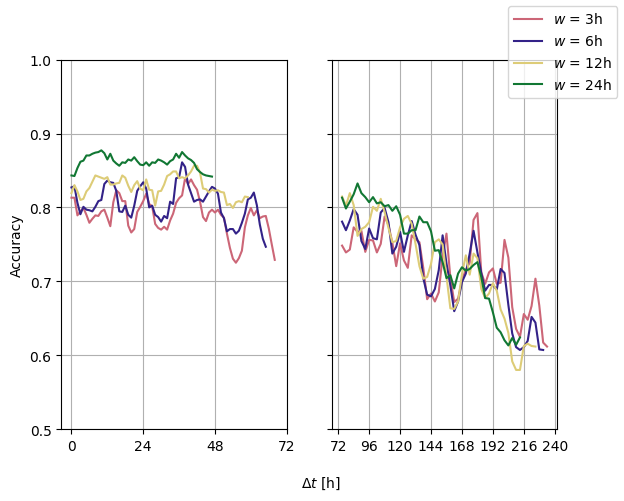

In [20]:
join_cols = ["station_id", "time"]

historical = pl.from_pandas(dataset_model_1.get_historical()).sort(join_cols)

time_col = pl.col("time")

forecast_1 = (
    pl.from_pandas(dataset_model_1.get_forecast())
    .sort(join_cols)
    .with_columns((time_col + datetime.timedelta(hours=1)).alias("time_end"))
)
forecast_2 = (
    pl.from_pandas(dataset_model_2.get_forecast())
    .sort(join_cols)
    .with_columns((time_col + datetime.timedelta(hours=3)).alias("time_end"))
)

forecast = forecast_1.vstack(forecast_2)

forecast_time_delta_expr = (
    (((pl.col("time") - pl.col("call_time")) / datetime.timedelta(hours=1)).round())
    .cast(pl.datatypes.Int32)
    .alias("forecast_time_delta_hours")
)

delta_time = pl.col("forecast_time_delta_hours")

accumulation_window_hours_selection = [
    3,
    6,
    12,
    24,
]

def get_model_1_data(
    accumulation_window_hours: int,
):
    return (0 <= delta_time) & (delta_time < (72 - accumulation_window_hours))

def get_model_2_data(
    accumulation_window_hours: int,
):
    assert (accumulation_window_hours % 3) == 0
    return (73 <= delta_time) & (
        delta_time < ((10 * 24) - accumulation_window_hours)
    )

# for some reason floating point accuracy messed up our 0.0 for some accumulations.
# so we remove that issue. Originally both forecast and historical data were given as integer as original value times 10.
# we go there for accumulation, and then back again
integerify_precipitation = (pl.col("^precipitation_.*$") * 10).cast(
    pl.datatypes.Int32
)
floatify_precipitation = (
    pl.col("^precipitation_.*$").cast(pl.datatypes.Float64) / 10
)
forecast = forecast.with_columns(integerify_precipitation, forecast_time_delta_expr)
historical = historical.with_columns(integerify_precipitation)

for accumulation_window_hours in accumulation_window_hours_selection:
    accumulation_timewindow = datetime.timedelta(hours=accumulation_window_hours)
    forecast_agg = forecast.rolling(
        time_col,
        period=accumulation_timewindow,
        by=["station_id", "call_time"],
        closed="left",
        offset=datetime.timedelta(),
    ).agg(
        pl.col("precipitation_forecast")
        .sum()
        .name.suffix(f"_{accumulation_window_hours}h")
    )

    historical_agg = (
        historical.rolling(
            time_col,
            period=accumulation_timewindow,
            by=["station_id"],
            closed="left",
            offset=datetime.timedelta(),
        ).agg(
            pl.col("precipitation_real")
            .sum()
            .name.suffix(f"_{accumulation_window_hours}h")
        )
        # .slice(offset=0, length=-int(12 / 1))
    )

    f_join_cols = [*join_cols, "call_time"]
    forecast = forecast.join(
        forecast_agg.select(
            [*f_join_cols, f"precipitation_forecast_{accumulation_window_hours}h"]
        ),
        on=f_join_cols,
        how="left",
    )
    h_join_cols = join_cols
    historical = historical.join(
        historical_agg.select(
            [*h_join_cols, f"precipitation_real_{accumulation_window_hours}h"]
        ),
        on=h_join_cols,
        how="left",
    )

forecast = forecast.with_columns(floatify_precipitation)

historical = historical.with_columns(floatify_precipitation)

print(forecast)

# print(
# historical.sort(join_cols).write_csv("whatever.csv"),#[13:],
# historical_accu.sort(join_cols).write_csv("whatever2.csv"),
# )

joined = forecast.join(historical, on=join_cols, how="left")

joined = (joined
    # .select(
    #     [
    #         "station_id",
    #         "forecast_time_delta_hours",
    #         "time",
    #         "call_time",
    #         "precipitation_real",
    #         "precipitation_forecast",
    #     ]
    # )
    .sort(["station_id", "forecast_time_delta_hours", "time"])
)
# print(joined.filter(pl.col("forecast_time_delta_hours") == 60))

# time_delt = pl.col("forecast_time_delta_hours")
# # (pl.col("station_id") == 5688) &
# print(joined.filter((61 <= time_delt) & (time_delt <= 71)))

# exit(0)

# we have no prediction for hour 71.
# this is at the border.
# TODO: validate that this is expected
# joined = joined.filter(pl.col("forecast_time_delta_hours") != 71)

# print(
# joined.write_csv("all_data.csv")
# )

# SIDEEFFECTS_setup_tueplot(relative_path_to_root=".")

SIDEEFFECTS_choose_color_palette()

fig, [ax1, ax2] = plt.subplots(ncols=2, sharey=True)
ax1: plt.Axes
ax2: plt.Axes

for accumulation_window_hours in accumulation_window_hours_selection:
    test_expr = (
        pl.col(f"precipitation_forecast_{accumulation_window_hours}h") > 0.0
    ) == (pl.col(f"precipitation_real_{accumulation_window_hours}h") > 0.0)

    correct_pred = (
        joined.group_by(["forecast_time_delta_hours"])
        .agg(
            (test_expr.sum().cast(pl.datatypes.Float64) / test_expr.count()).alias(
                f"accuracy_{accumulation_window_hours}h"
            )
        )
        .sort("forecast_time_delta_hours")
    )

    correct_pred_1 = correct_pred.filter(get_model_1_data(accumulation_window_hours))
    correct_pred_2 = correct_pred.filter(get_model_2_data(accumulation_window_hours))

    times_1 = correct_pred_1["forecast_time_delta_hours"]
    times_2 = correct_pred_2["forecast_time_delta_hours"]
    vals_1 = correct_pred_1[f"accuracy_{accumulation_window_hours}h"]
    vals_2 = correct_pred_2[f"accuracy_{accumulation_window_hours}h"]

    ax1.plot(
        times_1.to_numpy(),
        vals_1.to_numpy(),
        label=f"$w$ = {accumulation_window_hours}h",
        # c = choosen_palette[idx],
    )

    ax2.plot(
        times_2.to_numpy(),
        vals_2.to_numpy(),
        # label=f"$\Delta T$ = {accumulation_window_hours}h",
        # c = choosen_palette[idx],
    )
ax1.set_xticks(np.arange(0,73,24))
ax2.set_xticks(np.arange(72,243,24))
ax1.set_xlabel(" ")
ax2.set_xlabel(" ")
fig.text(0.5,-0.01,"$\Delta t$ [h]")
ax1.set_ylabel("Accuracy")  # over all stations and call times

ax1.set_ylim((0.5, 1))
ax1.grid(True)
ax2.grid(True)

fig.legend()

plt.savefig(os.path.join(FIG_SAVE_BASE_PATH,'fig_accuracy.pdf'))
